In [1]:
# ============================================================================
# CONFIGURAÇÕES
# ============================================================================
cnpj_fundo   = '10.500.884/0001-05' # REAL INVESTOR FUNDO DE INVESTIMENTO EM AÇÕES
data_inicial = '02/01/2022'
data_final   = '30/11/2025'


# '35.471.498/0001-55' # trigono flagship
# '48.931.854/0001-18' # avantgarde FIM
# '32.065.814/0001-09' # avantgarde FIA
# '73.232.530/0001-39' # DYNAMO COUGAR
# '10.500.884/0001-05' # REAL INVESTOR FUNDO DE INVESTIMENTO EM AÇÕES

In [2]:
import pandas as pd
import requests
import zipfile
import io
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import requests
from io import StringIO

def converter_data(data_str):
    """
    Converte string de data para formato datetime
    Aceita formatos: 'DD/MM/YYYY' ou 'YYYY-MM-DD'
    """
    formatos = ['%d/%m/%Y', '%Y-%m-%d', '%d-%m-%Y']
    
    for formato in formatos:
        try:
            return datetime.strptime(data_str, formato)
        except ValueError:
            continue
    
    raise ValueError(f"Formato de data não reconhecido: {data_str}. Use 'DD/MM/YYYY' ou 'YYYY-MM-DD'")



def regressao_statsmodels(X_train, y_train, X_test, y_test, mostrar_summary=True):
    """
    Regressão linear usando statsmodels com análise estatística completa
    
    Parâmetros:
    -----------
    X_train : DataFrame ou array
        Variáveis independentes (fatores) de treino
    y_train : Series ou array
        Variável dependente (retorno_excesso) de treino
    X_test : DataFrame ou array
        Variáveis independentes de teste
    y_test : Series ou array
        Variável dependente de teste
    mostrar_summary : bool
        Se True, imprime o resumo completo da regressão
    
    Retorna:
    --------
    dict : Dicionário com modelo e resultados
    """
    # Adicionar constante (intercepto)
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    # Ajustar o modelo
    modelo = sm.OLS(y_train, X_train_sm).fit()
    
    # Previsões
    y_pred_train = modelo.predict(X_train_sm)
    y_pred_test = modelo.predict(X_test_sm)
    
    # Calcular R² para teste
    r2_test = r2_score(y_test, y_pred_test)

     # Intercepto
    print(f"\nIntercepto (Alpha): {modelo.params['const']:.6f}")
    print(f"  Erro Padrão: {modelo.bse['const']:.6f}")
    print(f"  P-valor: {modelo.pvalues['const']:.6f}")
    
    # Coeficientes
    print("\nCoeficientes (Betas):")
    for nome in modelo.params.index:
        if nome != 'const':
            print(f"  {nome}:")
            print(f"    Coeficiente: {modelo.params[nome]:.6f}")
            print(f"    Erro Padrão: {modelo.bse[nome]:.6f}")
            print(f"    P-valor: {modelo.pvalues[nome]:.6f}")
    
    # Estatísticas gerais
    print("\n" + "-" * 80)
    print("ESTATÍSTICAS DO MODELO")
    print("-" * 80)
    print(f"R²: {modelo.rsquared:.4f}")
    print(f"R² Ajustado: {modelo.rsquared_adj:.4f}")
    print(f"Estatística F: {modelo.fvalue:.4f}")
    print(f"P-valor F: {modelo.f_pvalue:.6f}")
    
    if mostrar_summary:
        print("=" * 80)
        print("REGRESSÃO COM STATSMODELS --- SUMMARY")
        print("=" * 80)
        print(modelo.summary())
        print(f"\nR² dos dados de Teste: {r2_test:.4f}")
        print("=" * 80)
  
    return {
        'modelo': modelo,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'r2_train': modelo.rsquared,
        'r2_adj_train': modelo.rsquared_adj,
        'r2_test': r2_test,
        'coeficientes': modelo.params,
        'pvalores': modelo.pvalues,
        'intervalo_confianca': modelo.conf_int()
    }


def obter_anova_manual(resultado_statsmodels):
    """
    Cria tabela ANOVA manualmente a partir do resultado da regressao_statsmodels
    """
    import pandas as pd
    
    modelo = resultado_statsmodels['modelo']
    
    # Graus de liberdade
    df_model = modelo.df_model  # k (número de variáveis)
    df_resid = modelo.df_resid  # n - k - 1
    df_total = df_model + df_resid  # n - 1
    
    # Soma dos quadrados
    ss_model = modelo.ess  # Explained Sum of Squares (modelo)
    ss_resid = modelo.ssr  # Residual Sum of Squares (resíduo)
    ss_total = ss_model + ss_resid  # Total
    
    # Média dos quadrados
    ms_model = ss_model / df_model
    ms_resid = ss_resid / df_resid
    
    # Estatística F e p-valor
    f_stat = modelo.fvalue
    f_pvalue = modelo.f_pvalue
    
    # Criar tabela ANOVA
    anova_table = pd.DataFrame({
        'Fonte de Variação': ['Regressão', 'Resíduo', 'Total'],
        'GL': [int(df_model), int(df_resid), int(df_total)],
        'SQ': [ss_model, ss_resid, ss_total],
        'MQ': [ms_model, ms_resid, '-'],
        'F': [f'{f_stat:.4f}', '-', '-'],
        'P-valor': [f'{f_pvalue:.6f}' if f_pvalue < 0.001 else f'{f_pvalue:.4f}', '-', '-']
    })
    
    print("=" * 80)
    print("TABELA ANOVA")
    print("=" * 80)
    print(anova_table.to_string(index=False))
    print("=" * 80)
    print(f"\nR² = {modelo.rsquared:.4f} ({modelo.rsquared*100:.2f}% da variância explicada)")
    print(f"R² Ajustado = {modelo.rsquared_adj:.4f}")
    print("=" * 80)
    
    return anova_table

In [3]:
url = 'https://dados.cvm.gov.br/dados/FI/CAD/DADOS/registro_fundo_classe.zip'
response = requests.get(url)

# Abrir o ZIP em memória
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Listar arquivos no ZIP
    print(f"Arquivos no ZIP: {z.namelist()}")
    
    # Abrir especificamente o registro_fundo.csv
    csv_filename = 'registro_fundo.csv'
    print(f"Carregando: {csv_filename}")
    
    # Ler o CSV diretamente do ZIP
    with z.open(csv_filename) as f:
        df = pd.read_csv(f, sep=';', encoding='ISO-8859-1',
                         usecols=['CNPJ_Fundo', 
                                  'Codigo_CVM',
                                  'Denominacao_Social', 
                                  'Situacao', 'Data_Inicio_Situacao' , 'Data_Constituicao' , 'Gestor' ] )

df[df['CNPJ_Fundo']==int(''.join(filter(str.isdigit, cnpj_fundo)))]

Arquivos no ZIP: ['registro_classe.csv', 'registro_fundo.csv', 'registro_subclasse.csv']
Carregando: registro_fundo.csv


,CNPJ_Fundo,Codigo_CVM,Data_Constituicao,Denominacao_Social,Situacao,Data_Inicio_Situacao,Gestor
38862,10500884000105,176354,2012-02-06,REAL INVESTOR FIC DE FUNDOS DE INVESTIMENTO FI...,Em Funcionamento Normal,2012-02-10,REAL INVESTOR ASSET MANAGEMENT LTDA


In [4]:
def baixar_cotas_fundo_cvm(cnpj, data_inicio, data_fim):
    """
    Baixa cotas de fundo da CVM para um CNPJ específico em um período
    
    Args:
        cnpj: CNPJ do fundo (pode estar formatado ou não)
        data_inicio: Data inicial (string 'YYYY-MM-DD' ou datetime)
        data_fim: Data final (string 'YYYY-MM-DD' ou datetime)
    
    Returns:
        DataFrame com DT_COMPTC como index e VL_QUOTA como coluna
    """
    
    # Converter datas para datetime
    if isinstance(data_inicio, str):
        data_inicio = pd.to_datetime(data_inicio,dayfirst=True)
    if isinstance(data_fim, str):
        data_fim = pd.to_datetime(data_fim,dayfirst=True)
    
    ano_inicio = data_inicio.year
    ano_fim = data_fim.year
    
    print(f"Buscando dados de {data_inicio.date()} até {data_fim.date()}")
    print(f"CNPJ: {cnpj}\n")
    
    # Lista para armazenar DataFrames
    dfs = []
    
    # Processar cada ano
    for ano in range(ano_inicio, ano_fim + 1):
        print(f"=== Processando ano {ano} ===")
        
        if ano <= 2020:
            # Formato ZIP anual no diretório HIST (até 2020)
            dfs_ano = _baixar_ano_zip_hist(cnpj, ano)
            dfs.extend(dfs_ano)
        else:
            # Formato ZIP mensal (a partir de 2021)
            # Determinar meses a processar
            mes_inicio = data_inicio.month if ano == ano_inicio else 1
            mes_fim = data_fim.month if ano == ano_fim else 12
            
            for mes in range(mes_inicio, mes_fim + 1):
                df_mes = _baixar_mes_zip(cnpj, ano, mes)
                if df_mes is not None:
                    dfs.append(df_mes)
    
    # Concatenar todos os DataFrames
    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        
        # Converter DT_COMPTC para datetime
        df_final['DT_COMPTC'] = pd.to_datetime(df_final['DT_COMPTC'], format='%Y-%m-%d')
        
        # Filtrar pelo período solicitado
        df_final = df_final[(df_final['DT_COMPTC'] >= data_inicio) & 
                            (df_final['DT_COMPTC'] <= data_fim)]
        
        # Converter VL_QUOTA para float
        df_final['VL_QUOTA'] = df_final['VL_QUOTA'].astype(float)
        
        # Definir DT_COMPTC como index
        df_final.set_index('DT_COMPTC', inplace=True)
        
        # Ordenar por data
        df_final.sort_index(inplace=True)
        
        # Remover duplicatas (se houver)
        df_final = df_final[~df_final.index.duplicated(keep='first')]
        
        print(f"\n{'='*50}")
        print(f"Total de registros: {len(df_final)}")
        if len(df_final) > 0:
            print(f"Período: {df_final.index.min().date()} até {df_final.index.max().date()}")
        
        return df_final
    else:
        print("\nNenhum dado encontrado para este CNPJ no período")
        return pd.DataFrame()


def _baixar_ano_zip_hist(cnpj, ano):
    """Baixa dados de um ano completo em formato ZIP do diretório HIST (até 2020)"""
    url = f"https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/HIST/inf_diario_fi_{ano}.zip"
    
    print(f"Baixando ZIP: {url}")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
    except Exception as e:
        print(f"  ✗ Erro ao baixar: {e}")
        return []
    
    dfs = []
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        for mes in range(1, 13):
            csv_filename = f'inf_diario_fi_{ano}{mes:02d}.csv'
            
            try:
                with z.open(csv_filename) as f:
                    df_mes = pd.read_csv(f, sep=';', encoding='ISO-8859-1', low_memory=False)
                    
                    # Renomear coluna se necessário
                    if 'CNPJ_FUNDO_CLASSE' in df_mes.columns:
                        df_mes.rename(columns={'CNPJ_FUNDO_CLASSE': 'CNPJ_FUNDO'}, inplace=True)
                    
                    # Verificar se a coluna CNPJ_FUNDO existe
                    if 'CNPJ_FUNDO' not in df_mes.columns:
                        print(f"  ✗ Coluna CNPJ_FUNDO não encontrada. Colunas disponíveis: {df_mes.columns.tolist()}")
                        continue
                    
                    df_mes = df_mes[df_mes['CNPJ_FUNDO'] == cnpj]
                    
                    if not df_mes.empty:
                        df_mes = df_mes[['DT_COMPTC', 'VL_QUOTA']].copy()
                        dfs.append(df_mes)
                        print(f"  ✓ {csv_filename}: {len(df_mes)} registros")
                    
            except KeyError:
                pass  # Arquivo não existe no ZIP
    
    return dfs


def _baixar_mes_zip(cnpj, ano, mes):
    """Baixa dados de um mês específico em formato ZIP (a partir de 2021)"""
    url = f"https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{ano}{mes:02d}.zip"
    
    print(f"Baixando ZIP: {url}")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
        
        # Descompactar e ler o CSV
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_filename = f'inf_diario_fi_{ano}{mes:02d}.csv'
            
            with z.open(csv_filename) as f:
                df = pd.read_csv(f, sep=';', encoding='ISO-8859-1', low_memory=False)
                
                # Renomear coluna se necessário
                if 'CNPJ_FUNDO_CLASSE' in df.columns:
                    df.rename(columns={'CNPJ_FUNDO_CLASSE': 'CNPJ_FUNDO'}, inplace=True)
                
                # Verificar se a coluna CNPJ_FUNDO existe
                if 'CNPJ_FUNDO' not in df.columns:
                    print(f"  ✗ Coluna CNPJ_FUNDO não encontrada. Colunas disponíveis: {df.columns.tolist()}")
                    return None
                
                df = df[df['CNPJ_FUNDO'] == cnpj]
                
                if not df.empty:
                    df = df[['DT_COMPTC', 'VL_QUOTA']].copy()
                    print(f"  ✓ {len(df)} registros")
                    return df
                else:
                    print(f"  ○ Nenhum registro para este CNPJ")
                    return None
            
    except Exception as e:
        print(f"  ✗ Erro: {e}")
        return None


In [5]:
vl_cota = baixar_cotas_fundo_cvm(cnpj_fundo, data_inicial, data_final)

Buscando dados de 2022-01-02 até 2025-11-30
CNPJ: 10.500.884/0001-05

=== Processando ano 2022 ===
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202201.zip
  ✓ 21 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202202.zip
  ✓ 19 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202203.zip
  ✓ 22 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202204.zip
  ✓ 19 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202205.zip
  ✓ 22 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202206.zip
  ✓ 21 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202207.zip
  ✓ 21 registros
Baixando ZIP: https://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_202208.zip
  ✓ 23 registros
Baixando ZIP:

In [6]:
vl_cota['retorno'] = np.log(vl_cota['VL_QUOTA']) - np.log(vl_cota['VL_QUOTA'].shift(1))

In [7]:
url = 'https://nefin.com.br/resources/risk_factors/nefin_factors.csv'
nefin = pd.read_csv(url, index_col='Date', parse_dates=True,
                    usecols=lambda x: x != 'Unnamed: 0'  # Ignora a coluna 'Unnamed: 0'
)
nefin = nefin.rename(columns={'Rm_minus_Rf': 'Market'})

# nefin[converter_data(data_inicial):converter_data(data_final)]


In [8]:
# Calcular retorno em excesso (join automático pelos índices)
vl_cota['retorno_excesso'] = vl_cota['retorno'] - nefin['Risk_Free']
# Juntar os dataframes pelo índice (Date)
dados = vl_cota.join(nefin, how='inner')

# Remover linhas com NaN
dados = dados.dropna()
dados

,VL_QUOTA,retorno,retorno_excesso,Market,SMB,HML,WML,IML,Risk_Free
2022-01-04,14.161991,-0.012789,-0.013141,-0.005392,-0.025037,0.011632,0.011253,-0.022492,0.000352
2022-01-05,13.739627,-0.030278,-0.030632,-0.028089,-0.025251,0.008818,0.001597,-0.017956,0.000354
2022-01-06,13.706812,-0.002391,-0.002745,0.001800,-0.013514,-0.011414,-0.003626,-0.006779,0.000354
2022-01-07,13.730695,0.001741,0.001385,0.007041,0.009067,-0.001449,0.004623,0.009456,0.000356
2022-01-10,13.664998,-0.004796,-0.005158,-0.008797,-0.009789,0.004138,0.013777,-0.009837,0.000361
...,...,...,...,...,...,...,...,...,...
2025-11-24,26.441329,0.011950,0.011399,0.003594,-0.007467,0.002392,0.014344,-0.003190,0.000551
2025-11-25,26.537756,0.003640,0.003089,0.002810,0.009173,0.010454,-0.002400,0.005789,0.000551
2025-11-26,26.881037,0.012853,0.012302,0.015611,0.015062,-0.010893,-0.003167,-0.000261,0.000551
2025-11-27,26.875404,-0.000210,-0.000761,-0.001297,0.020286,0.002862,0.000247,0.007128,0.000551


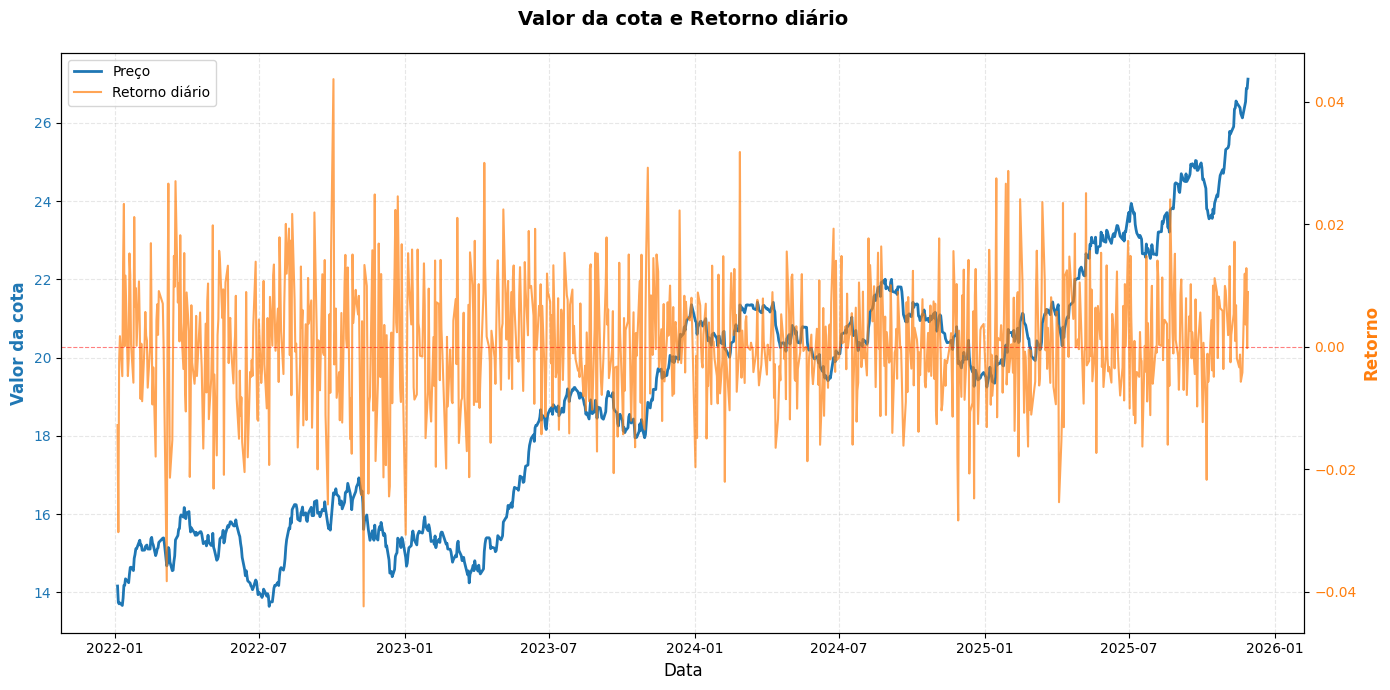

In [9]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eixo esquerdo - Preço
color1 = '#1f77b4'
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Valor da cota', color=color1, fontsize=12, fontweight='bold')
line1 = ax1.plot(dados.index, dados['VL_QUOTA'], color=color1, linewidth=2, label='Preço')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')

# Eixo direito - Retorno
ax2 = ax1.twinx()
color2 = '#ff7f0e'
ax2.set_ylabel('Retorno', color=color2, fontsize=12, fontweight='bold')
line2 = ax2.plot(dados.index, dados['retorno'], color=color2, linewidth=1.5, alpha=0.7, label='Retorno diário')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Legenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.title('Valor da cota e Retorno diário', fontsize=14, fontweight='bold', pad=20)
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [10]:
proporcao_treino=2/3
n_treino = int(len(dados) * proporcao_treino)
n_treino = int(len(dados) * proporcao_treino)
treino = dados.iloc[:n_treino]
teste = dados.iloc[n_treino:]
print(f"Treino: {len(treino)} observações ({treino.index[0]} a {treino.index[-1]})")
print(f"Teste: {len(teste)} observações ({teste.index[0]} a {teste.index[-1]})")


# Definir variáveis independentes (fatores) e dependente (retorno_excesso)
fatores = ['Market', 'SMB', 'HML', 'WML']

X_train = treino[fatores]
y_train = treino['retorno_excesso']

X_test = teste[fatores]
y_test = teste['retorno_excesso']

Treino: 652 observações (2022-01-04 00:00:00 a 2024-08-12 00:00:00)
Teste: 326 observações (2024-08-13 00:00:00 a 2025-11-28 00:00:00)


In [11]:
print(
    df.loc[
        df['CNPJ_Fundo'] == int(''.join(filter(str.isdigit, cnpj_fundo))),
        'Denominacao_Social'
    ].to_string(index=False)
)

resultado_sm = regressao_statsmodels(X_train, y_train, X_test, y_test)
obter_anova_manual(resultado_sm)


REAL INVESTOR FIC DE FUNDOS DE INVESTIMENTO FIN...

Intercepto (Alpha): 0.000070
  Erro Padrão: 0.000129
  P-valor: 0.585484

Coeficientes (Betas):
  Market:
    Coeficiente: 0.845713
    Erro Padrão: 0.013575
    P-valor: 0.000000
  SMB:
    Coeficiente: 0.282506
    Erro Padrão: 0.017577
    P-valor: 0.000000
  HML:
    Coeficiente: 0.067013
    Erro Padrão: 0.019718
    P-valor: 0.000719
  WML:
    Coeficiente: 0.055284
    Erro Padrão: 0.016272
    P-valor: 0.000722

--------------------------------------------------------------------------------
ESTATÍSTICAS DO MODELO
--------------------------------------------------------------------------------
R²: 0.9016
R² Ajustado: 0.9010
Estatística F: 1482.6350
P-valor F: 0.000000
REGRESSÃO COM STATSMODELS --- SUMMARY
                            OLS Regression Results                            
Dep. Variable:        retorno_excesso   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:            

,Fonte de Variação,GL,SQ,MQ,F,P-valor
0,Regressão,4,0.062906,0.015726,1482.6350,0.000000
1,Resíduo,647,0.006863,0.000011,-,-
2,Total,651,0.069768,-,-,-


In [12]:
# Extrair betas (sem o intercepto)
betas = resultado_sm['coeficientes'][['Market', 'HML', 'WML', 'SMB']].values
intercepto = resultado_sm['coeficientes']['const']

# MATRIZ.MULT equivalente em Python
fatores_matrix = teste[['Market', 'HML', 'WML', 'SMB']].values
retorno_fatores = np.dot(fatores_matrix, betas)

# Adicionar intercepto e Risk_Free
retorno_reconstruido = intercepto + retorno_fatores + teste['Risk_Free'].values

# Criar Series com o resultado
retorno_reconstruido = pd.Series(
    retorno_reconstruido, 
    index = teste.index, 
    name  = 'retorno_reconstruido'
)


# Calcular erro
erro = retorno_reconstruido - teste['retorno_excesso'].values

print(f"Erro médio: {np.mean(erro):.6f}")
print(f"RMSE: {np.sqrt(np.mean(erro**2)):.6f}")

retorno_reconstruido

Erro médio: 0.000596
RMSE: 0.010719


2024-08-13    0.001257
2024-08-14    0.001354
2024-08-15    0.004513
2024-08-16   -0.002154
2024-08-19    0.011901
                ...   
2025-11-24    0.002505
2025-11-25    0.006157
2025-11-26    0.017174
2025-11-27    0.005461
2025-11-28    0.010417
Name: retorno_reconstruido, Length: 326, dtype: float64

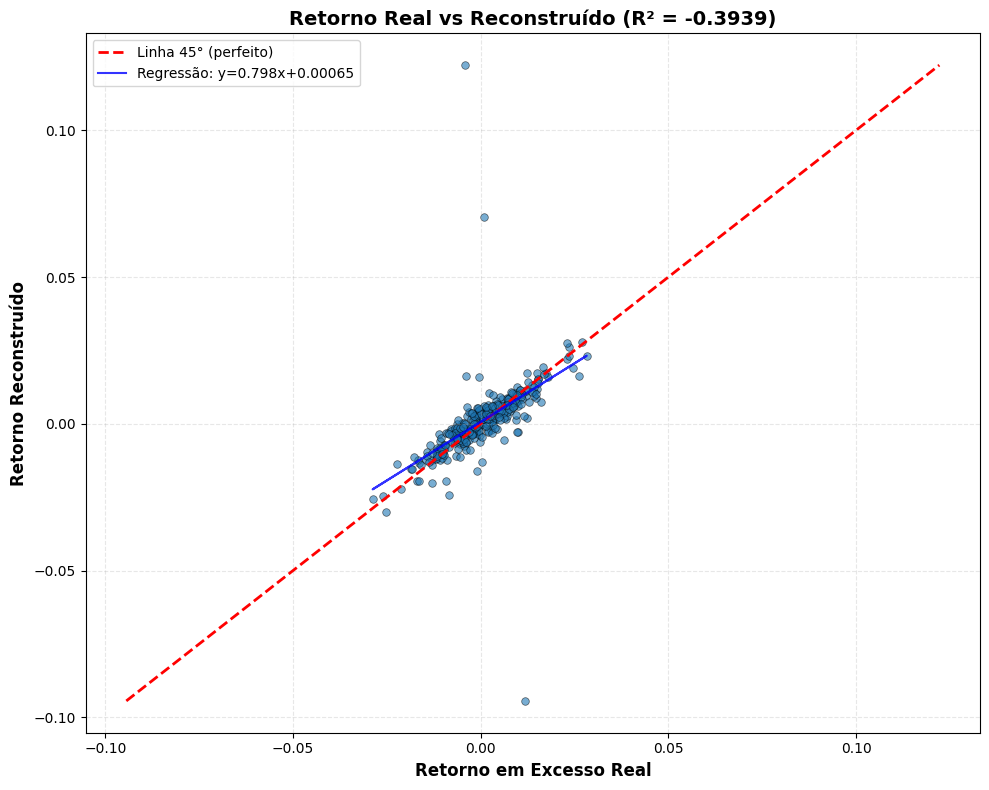

R² do ajuste: -0.3939
Correlação: 0.5664


In [13]:
# Alinhar índices
comum = teste.index.intersection(teste.index)
real = teste.loc[comum, 'retorno_excesso'].values
reconstruido = retorno_reconstruido[:len(comum)]

# Criar scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(real, reconstruido, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Linha de 45 graus (predição perfeita)
min_val = min(real.min(), reconstruido.min())
max_val = max(real.max(), reconstruido.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Linha 45° (perfeito)')

# Linha de regressão
z = np.polyfit(real, reconstruido, 1)
p = np.poly1d(z)
plt.plot(real, p(real), 'b-', linewidth=1.5, alpha=0.8, label=f'Regressão: y={z[0]:.3f}x+{z[1]:.5f}')

# Calcular R²
r2 = r2_score(real, reconstruido)

plt.xlabel('Retorno em Excesso Real', fontsize=12, fontweight='bold')
plt.ylabel('Retorno Reconstruído', fontsize=12, fontweight='bold')
plt.title(f'Retorno Real vs Reconstruído (R² = {r2:.4f})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"R² do ajuste: {r2:.4f}")
print(f"Correlação: {np.corrcoef(real, reconstruido)[0,1]:.4f}")

In [14]:
# # Histograma dos erros
# plt.figure(figsize=(12, 6))

# # Histograma
# plt.hist(erro, bins=50, edgecolor='black', alpha=0.7, color='steelblue')

# # Linha vertical no zero
# plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')

# # Linha vertical na média
# plt.axvline(x=erro.mean(), color='green', linestyle='--', linewidth=2, label=f'Média = {erro.mean():.6f}')

# # Estatísticas
# plt.xlabel('Erro (Reconstruído - Real)', fontsize=12, fontweight='bold')
# plt.ylabel('Frequência', fontsize=12, fontweight='bold')
# plt.title('Distribuição dos Erros de Reconstrução', fontsize=14, fontweight='bold')
# plt.legend(fontsize=10)
# plt.grid(True, alpha=0.3, axis='y')

# # estatísticas
# stats_text = f'Média: {erro.mean():.6f}\nDesvio Padrão: {erro.std():.6f}\nMínimo: {erro.min():.6f}\nMáximo: {erro.max():.6f}'
# plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
#          fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# plt.tight_layout()
# plt.show()


In [15]:
print("=" * 60)
print("ESTATÍSTICAS DOS ERROS")
print("=" * 60)
print(f"Média: {erro.mean():.6f}")
print(f"Mediana: {np.median(erro):.6f}")
print(f"Desvio Padrão: {erro.std():.6f}")
print(f"Mínimo: {erro.min():.6f}")
print(f"Máximo: {erro.max():.6f}")
print(f"RMSE: {np.sqrt(np.mean(erro**2)):.6f}")
print("=" * 60)

ESTATÍSTICAS DOS ERROS
Média: 0.000596
Mediana: 0.000474
Desvio Padrão: 0.010719
Mínimo: -0.106182
Máximo: 0.126254
RMSE: 0.010719


In [16]:
import re
pattern = re.compile(
   r"fator|factor|bayes|quant|sistemat|sistemát",  
    re.IGNORECASE 
)

quant_fundos = df[
    (df["Situacao"].str.contains("Normal")) &
    (df["Denominacao_Social"].str.contains(pattern, na=False))
]

with pd.option_context('display.max_rows', None):
    display(
quant_fundos[[
    "Denominacao_Social",
    "CNPJ_Fundo",
    "Codigo_CVM",
    "Situacao"
]].sort_values("Denominacao_Social")
    )

,Denominacao_Social,CNPJ_Fundo,Codigo_CVM,Situacao
81712,ACS QUANTITAS PREVIDÊNCIA FI EM COTAS DE FUNDO...,57378527000171,549410,Em Funcionamento Normal
77739,ASA QUANT CLASSE DE INVESTIMENTO MULTIMERCADO...,52321166000103,509965,Em Funcionamento Normal
77743,ASA QUANT CLASSE DE INVESTIMENTO EM COTAS DE ...,52323731000171,510000,Em Funcionamento Normal
27761,ATALAIA QUANT INSTITUCIONAL MULTIMERCADO FUNDO...,3564113000108,6750,Em Funcionamento Normal
75013,AVANTGARDE MULTIFATORES ABSOLUTO FUNDO DE INVE...,48931854000118,483550,Em Funcionamento Normal
58525,AVANTGARDE MULTIFATORES FUNDO DE INVESTIMENTO ...,32065814000109,331643,Em Funcionamento Normal
63015,AZ QUEST BAYES LONG BIASED SISTEMATICO FUNDO D...,36499625000197,360953,Em Funcionamento Normal
63014,AZ QUEST BAYES LONG BIASED SISTEMATICO FUNDO D...,36499625000197,360953,Em Funcionamento Normal
73953,AZ QUEST BAYES LONG SHORT SISTEMÁTICO FI EM CO...,46929688000190,468096,Em Funcionamento Normal
73952,AZ QUEST BAYES LONG SHORT SISTEMÁTICO FI EM CO...,46929688000190,468096,Em Funcionamento Normal
